<a href="https://colab.research.google.com/github/bidishaaiml/COE_week10/blob/main/Indoor_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Object Detection Using YOLO (You Only Look Once)**

YOLO (You Only Look Once) is a real-time object detection algorithm that processes images quickly and accurately by framing the task as a single regression problem. Unlike traditional methods that classify multiple regions, YOLO divides an image into a grid and predicts bounding boxes and class probabilities simultaneously for each grid cell. This unified approach enables high-speed performance, making YOLO suitable for applications like autonomous vehicles and surveillance.

With versions like YOLOv3, YOLOv5, and YOLOv8, the algorithm has improved in terms of accuracy and efficiency.
In this project, I utilized the Roboflow API to implement the YOLO model, streamlining the process of model training and inference. While YOLO excels in real-time detection and generalization across various object categories, it may struggle with small or densely packed objects. Overall, YOLO has revolutionized object detection in computer vision by offering a blend of speed and effectiveness.

# **Downloading The Dataset**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
# Initializing Roboflow with your API key

rf = Roboflow(api_key="N2fiezX7PCu3oXDEYnld")
# Accessing the specific project and version

project = rf.workspace("so-d4hcz").project("all_finalize")
version = project.version(3)

# Downloading the dataset in YOLOv7 format
dataset = version.download("yolov7")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to all_finalize--3 in yolov7pytorch:: 100%|██████████| 12566/12566 [00:02<00:00, 6107.25it/s]


In [ ]:
# Verifying the download
print(dataset.location)

/content/all_finalize--3


In [ ]:
! pip install ultralytics
! pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

# **Importing Necessary Libraries**

In [ ]:
#importing all the required packages
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil


%matplotlib inline


In [ ]:
root_dir="/content/all_finalize--3"
train_imgs_dir="/content/all_finalize--3/train/images"
valid_imgs_dir="/content/all_finalize--3/valid/images"
test_imgs_dir="/content/all_finalize--3/test/images"

In [ ]:
train_labels_dir="/content/all_finalize--3/train/labels"
valid_labels_dir="/content/all_finalize--3/valid/labels"
test_labels_dir="/content/all_finalize--3/test/labels"

# **Mapping Class Indices to Class names**

In [ ]:
# Defining a dictionary to map class indices to class names for various indoor objects
names={0:'AC',1:'Bathtub',2:'Bed Frame',3:'Bed',4:'Closet',5:'Cupboard',6:'Desk',7:'Dining Table',8:'Dish Washer',9:'Door',10:'Exhaust Fan',11:'Exhaust Hood',12:'Faucet',13:'Fridge',14:'Microwave',15:'Oven',16:'Sink',17:'Sofa',18:'Stove',19:'TV',20:'Thermo Ventilator',21:'Toilet Sink',22:'Toilet',23:'Washing Machine',24:'Water Cubicle',25:'Water Heater',26:'Windowsill'}
# Generating an array of random colors for visualizing bounding boxes
# The array has shape (10, 3), indicating 10 colors with 3 values (RGB) each
COLORS=np.random.uniform(0,255,(10,3))

# **Displaying the image bounded boxes**

In [ ]:
def show_bbox(img_name,img_dir,label_dir,axis):
    """
    Displaying an image with bounding boxes and labels drawn around detected objects.

    Parameters:
    - img_name (str): The name of the image file to be displayed.
    - img_dir (str): The directory containing the image files.
    - label_dir (str): The directory containing the label files corresponding to the images.
    - axis: The matplotlib axis object on which to display the image.

    The function reads the specified image and its corresponding label file. It then extracts the bounding box
    coordinates and class labels for each detected object. The bounding boxes are drawn on the image using
    random colors, and the corresponding class labels are displayed above the boxes. If the label file is not found,
    it gracefully skips drawing boxes.
    """
    img_path=os.path.join(img_dir,img_name)
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w,_=img.shape
    img=img.copy()

    try:
        label_path=os.path.join(label_dir,img_name[:-4]+".txt")
        label=pd.read_csv(label_path,sep=" ",header=None).values
        classes=label[:,0]
        boxes=label[:,1:]

        for i,box in enumerate(boxes):
            cls_id=int(classes[i])
            text=names[cls_id]
            color=COLORS[cls_id]
            xmin=int((box[0]-box[2]/2)*w)
            ymin=int((box[1]-box[3]/2)*h)
            xmax=int((box[0]+box[2]/2)*w)
            ymax=int((box[1]+box[3]/2)*h)
            cv2.rectangle(img,(xmin,ymin),(xmax,ymax),color,3)
            y=ymin-10 if ymin-10>10 else ymin+20
            cv2.putText(img,text,(xmin,y),cv2.FONT_HERSHEY_SIMPLEX,1.5,color,3)
    except:
        pass

    axis.imshow(img)
    axis.axis("off")

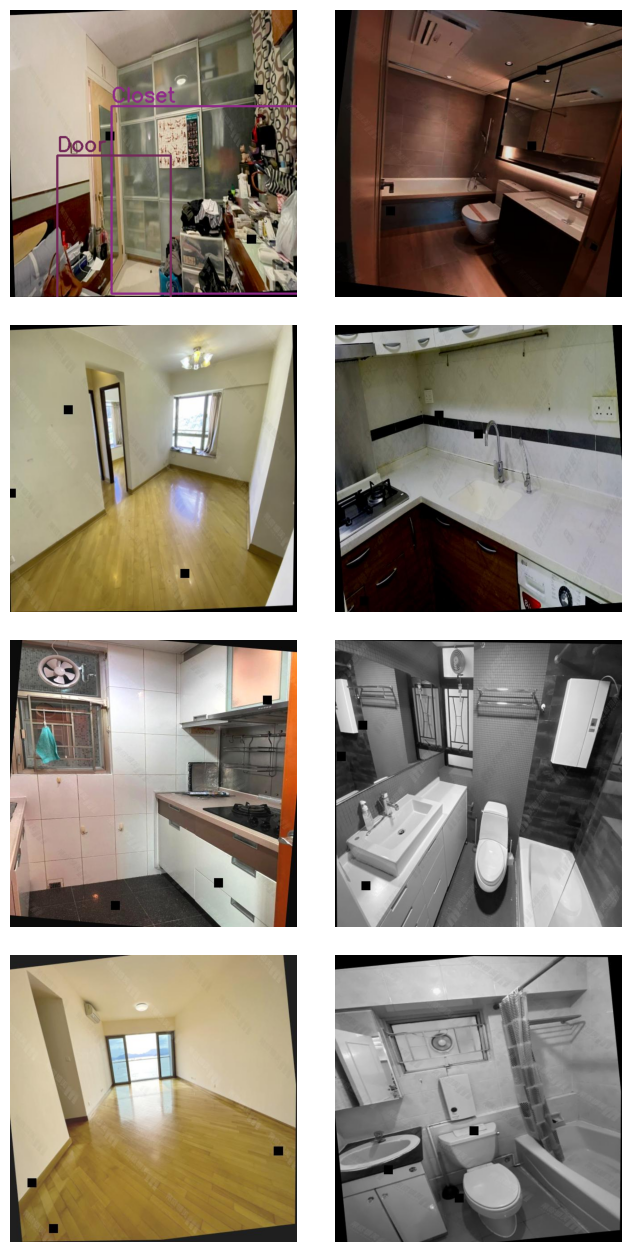

In [ ]:
# Creating a subplot grid to visualize images with bounding boxes for the training dataset
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()


train_img_list=sorted(os.listdir(train_imgs_dir))
img_name_list=np.random.choice(train_img_list,8)


for i,img_name in enumerate(img_name_list):
    show_bbox(img_name,train_imgs_dir,train_labels_dir,ax[i])

plt.savefig("1.png")

# **YOLO format Configuration**

In [ ]:
# Defining a dictionary to store YOLO format configuration for the dataset
yolo_format=dict(path=root_dir,              # Root directory where the dataset is located
                 train=train_imgs_dir,       # Directory containing training images
                 val=valid_imgs_dir,         # Directory containing validation images
                 nc=27,                      # Number of classes
                 names=names)                # Dictionary mapping class indices to class names

# Writing the YOLO format configuration to a YAML file
with open('/content/all_finalize--3/data.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)# Saving the dictionary in YAML format without flow style

In [ ]:
!pip install inference

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.0/906.0 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 10.5 MB/s eta 0:00:00
   ━━━━

# **Object Detection Inference Using API**

In [ ]:
from inference_sdk import InferenceHTTPClient
import base64

# Initializing the InferenceHTTPClient to interact with the Roboflow API for object detection
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",  # API endpoint for Roboflow inference
    api_key="N2fiezX7PCu3oXDEYnld")         # API key for authentication

# Loading the image and encoding it in base64
with open("/content/all_finalize--3/train/images/114_jpg.rf.28048ff25e74aeb64a1008e68fb13d74.jpg", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode('utf-8')

# Calling the infer function with the encoded image data
result = CLIENT.infer(encoded_string, model_id="all_finalize/3")
print(result)

{'inference_id': '5e412ed6-fd78-4cec-8792-81391f452ee9', 'time': 0.035875384000064514, 'image': {'width': 640, 'height': 640}, 'predictions': [{'x': 209.0, 'y': 472.5, 'width': 196.0, 'height': 151.0, 'confidence': 0.8714888095855713, 'class': 'Cupboard', 'class_id': 5, 'detection_id': '301ac0b3-1dd4-4fea-ac5c-b783a7b373b6'}, {'x': 382.5, 'y': 326.0, 'width': 33.0, 'height': 58.0, 'confidence': 0.8105806112289429, 'class': 'Microwave', 'class_id': 14, 'detection_id': 'f3a6d3a6-fa0f-46f5-a0d0-8043da0805a5'}, {'x': 333.0, 'y': 404.0, 'width': 124.0, 'height': 46.0, 'confidence': 0.8018642663955688, 'class': 'Stove', 'class_id': 18, 'detection_id': '1be4b8f6-b148-44cc-b310-e6e894770109'}, {'x': 176.0, 'y': 256.5, 'width': 38.0, 'height': 29.0, 'confidence': 0.7854049205780029, 'class': 'Exhaust Fan', 'class_id': 10, 'detection_id': 'ebce377d-c844-4850-9dac-94937a5b0b66'}, {'x': 182.5, 'y': 391.0, 'width': 129.0, 'height': 22.0, 'confidence': 0.775198221206665, 'class': 'Sink', 'class_id':

# **YOLO Model Training**

In [ ]:
# Loading the YOLOv8 model using a pretrained weights file
model=YOLO('yolov8l.pt')

# Training the YOLO model with the specified configuration
model.train(data="/content/all_finalize--3/data.yaml",epochs=20,patience=20,batch=8,
            lr0=0.0003,imgsz=640,freeze=6)

 """Path to the YAML file containing dataset configuration
    epochs=20,                                  # Number of training epochs
    patience=20,                                # Number of epochs with no improvement before early stopping
    batch=8,                                    # Number of samples per gradient update (batch size)
    lr0=0.0003,                                 # Initial learning rate
    imgsz=640,                                  # Image size for training (640x640)
    freeze=6                                    # Number of initial layers to freeze during training"""

100%|██████████| 83.7M/83.7M [00:01<00:00, 48.0MB/s]


Ultralytics YOLOv8.2.66 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/all_finalize--3/data.yaml, epochs=20, time=None, patience=20, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=6, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

100%|██████████| 755k/755k [00:00<00:00, 4.61MB/s]


Overriding model.yaml nc=80 with nc=27

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytic

100%|██████████| 6.25M/6.25M [00:00<00:00, 22.1MB/s]


AMP: checks passed ✅


train: Scanning /content/all_finalize--3/train/labels... 5493 images, 1881 backgrounds, 0 corrupt: 100%|██████████| 5493/5493 [00:07<00:00, 726.56it/s]


train: New cache created: /content/all_finalize--3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/all_finalize--3/valid/labels... 520 images, 178 backgrounds, 0 corrupt: 100%|██████████| 520/520 [00:00<00:00, 597.99it/s]

val: New cache created: /content/all_finalize--3/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0003' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000323, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.23G      1.062      2.281      1.316         11        640: 100%|██████████| 687/687 [03:50<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:12<00:00,  2.55it/s]

                   all        520       1325      0.579      0.385      0.387      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.54G       1.08      1.749      1.332         30        640: 100%|██████████| 687/687 [03:39<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.94it/s]


                   all        520       1325      0.603      0.483      0.436      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.54G      1.074      1.641      1.331         14        640: 100%|██████████| 687/687 [03:36<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.07it/s]


                   all        520       1325      0.522      0.469      0.457      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.52G      1.049      1.529      1.314         28        640: 100%|██████████| 687/687 [03:35<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.03it/s]


                   all        520       1325      0.559      0.553      0.508      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.52G     0.9927      1.379      1.275         16        640: 100%|██████████| 687/687 [03:35<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.01it/s]


                   all        520       1325      0.476      0.576      0.492       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.52G     0.9549       1.28      1.249         36        640: 100%|██████████| 687/687 [03:34<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.04it/s]


                   all        520       1325        0.6      0.596      0.536      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.54G     0.9157      1.178      1.213         14        640: 100%|██████████| 687/687 [03:33<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.06it/s]


                   all        520       1325      0.607      0.526      0.534      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.52G     0.8776      1.086      1.189         28        640: 100%|██████████| 687/687 [03:35<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.02it/s]


                   all        520       1325      0.596      0.593      0.563      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.55G     0.8544       1.04      1.174         17        640: 100%|██████████| 687/687 [03:34<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.97it/s]


                   all        520       1325      0.558      0.654      0.548      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.38G     0.8265     0.9689      1.153         17        640: 100%|██████████| 687/687 [03:36<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.07it/s]

                   all        520       1325      0.674      0.524      0.555      0.424


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.53G     0.7957     0.7716      1.156         12        640: 100%|██████████| 687/687 [03:33<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.08it/s]

                   all        520       1325      0.601      0.635      0.581      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.52G     0.7593     0.7034      1.124          9        640: 100%|██████████| 687/687 [03:32<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.07it/s]

                   all        520       1325      0.605      0.592       0.57      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.53G     0.7349     0.6474      1.107          4        640: 100%|██████████| 687/687 [03:32<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.99it/s]


                   all        520       1325      0.589      0.633       0.59      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.53G     0.7093      0.601      1.083         20        640: 100%|██████████| 687/687 [03:32<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.01it/s]

                   all        520       1325      0.586       0.62      0.582      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.53G     0.6842     0.5487      1.063          9        640: 100%|██████████| 687/687 [03:32<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.08it/s]


                   all        520       1325       0.62      0.599      0.601      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.52G     0.6645     0.5164      1.057         24        640: 100%|██████████| 687/687 [03:31<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.04it/s]


                   all        520       1325      0.669      0.587      0.604      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.52G     0.6369     0.4695      1.034         14        640: 100%|██████████| 687/687 [03:31<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.97it/s]


                   all        520       1325      0.585      0.618      0.581      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.37G     0.6115     0.4357      1.018         22        640: 100%|██████████| 687/687 [03:31<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.98it/s]

                   all        520       1325      0.645      0.605      0.608      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       3.5G     0.5991     0.4045      1.004         16        640: 100%|██████████| 687/687 [03:31<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


                   all        520       1325      0.654      0.588      0.616      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.51G     0.5772     0.3884     0.9959         21        640: 100%|██████████| 687/687 [03:30<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.98it/s]

                   all        520       1325      0.637      0.604      0.617      0.483



20 epochs completed in 1.295 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 87.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43,627,425 parameters, 0 gradients, 164.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:11<00:00,  2.87it/s]


                   all        520       1325      0.636      0.604      0.617      0.483
                    AC         49         53      0.513      0.397      0.456      0.392
               Bathtub         46         46      0.792      0.891      0.832      0.716
             Bed Frame         16         16      0.711       0.75      0.753      0.582
                   Bed          7          7      0.445      0.429      0.564      0.415
                Closet         15         16      0.662      0.368      0.465      0.439
              Cupboard        118        208      0.584       0.54       0.58      0.432
                  Desk          4          4          1          0          0          0
          Dining Table          5          5          0          0     0.0616     0.0332
                  Door         13         13      0.439      0.692      0.536      0.417
           Exhaust Fan         59         59      0.706      0.831       0.77      0.546
          Exhaust Hoo

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f7dce3c5f00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.04104

# **Model Evaluation**

In [ ]:
# Defining the path to the best weights file from the training results
path_best_weights="/content/runs/detect/train/weights/best.pt" # Path to the best model weights

# Loading the YOLO model using the best weights from training
model = YOLO(path_best_weights)

# Evaluating the model on the validation dataset with specified confidence and IoU thresholds
metrics = model.val(conf=0.20,iou=0.70)  # Confidence threshold for considering a prediction as valid
# Intersection over Union (IoU) threshold for evaluating bounding box accuracy

Ultralytics YOLOv8.2.66 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43,627,425 parameters, 0 gradients, 164.9 GFLOPs


val: Scanning /content/all_finalize--3/valid/labels.cache... 520 images, 178 backgrounds, 0 corrupt: 100%|██████████| 520/520 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:23<00:00,  1.39it/s]


                   all        520       1325        0.6      0.604      0.611      0.497
                    AC         49         53       0.52      0.408      0.456      0.402
               Bathtub         46         46      0.792      0.891      0.833      0.744
             Bed Frame         16         16       0.71       0.75      0.788      0.641
                   Bed          7          7      0.448      0.429      0.512      0.395
                Closet         15         16      0.659      0.363      0.479      0.464
              Cupboard        118        208      0.584      0.547      0.576      0.455
                  Desk          4          4          1          0          0          0
          Dining Table          5          5          0          0          0          0
                  Door         13         13      0.436      0.692      0.558       0.46
           Exhaust Fan         59         59      0.706      0.831      0.768      0.562
          Exhaust Hoo

# **Average Precision**

In [ ]:
# Printing evaluation metrics for the model's performance based on Mean Average Precision (mAP)
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")
print(f"Mean Average Precision @ .50   : {metrics.box.map50}")
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.4968462812865433
Mean Average Precision @ .50   : 0.611317805660345
Mean Average Precision @ .70   : 0.5511704300584183


Overall Inference:
The model demonstrates acceptable performance at a 50% IoU threshold, indicating it can detect objects effectively with some margin for error. However, its performance declines at higher IoU thresholds, suggesting potential issues with accurately localizing objects.
The average performance across the range of thresholds (0.5 to 0.95) further emphasizes that while the model is somewhat effective, there is significant room for improvement, especially in terms of increasing the accuracy of the bounding boxes it predicts.


In [ ]:
columns=["Mean_Avg_Precision"]
cls_map=pd.DataFrame(metrics.box.maps,columns=columns,index=names.values())
cls_map.style.background_gradient(subset=columns,cmap="YlOrRd",high=0.75)

,Mean_Avg_Precision
AC,0.402224
Bathtub,0.743865
Bed Frame,0.641255
Bed,0.394561
Closet,0.464092
Cupboard,0.455360
Desk,0.000000
Dining Table,0.000000
Dish Washer,0.496846
Door,0.460143


Overall Performance Overview

The model demonstrates varying levels of performance across different object classes, with some classes showing strong detection capabilities while others are underperforming.

Classes with High Performance

Toilet Sink: 0.853

This class has the highest mAP, indicating that the model effectively detects and localizes toilet sinks with a high degree of accuracy.

Sofa: 0.796

The sofa also has a strong performance, suggesting that the model reliably identifies and locates sofas in images.

Water Heater: 0.778

This class shows good detection performance, indicating that the model can effectively recognize water heaters.

Bathtub: 0.744

The bathtub also performs well, reflecting strong detection capabilities for this class.

Microwave: 0.577

The microwave has a decent score, showing that the model can detect microwaves effectively, but there may still be room for improvement.

Classes with Moderate Performance

Fridge: 0.572

The model performs reasonably well in detecting fridges, but further refinements may be needed.

Exhaust Fan: 0.562

The performance is moderate; the model can detect exhaust fans, but improvements could be made.

Exhaust Hood: 0.577

Similar to the exhaust fan, the detection of exhaust hoods is acceptable but could be enhanced.

Dish Washer: 0.497

The detection of dishwashers is on the lower side, indicating that there might be challenges in accurately recognizing this class.

Stove: 0.638

The model has a decent performance in detecting stoves, but there may be some inconsistencies.

Classes with Low Performance

Desk: 0.000

The model fails to detect desks at all, indicating a significant issue that may require more training data or adjustments in the model.

Dining Table: 0.000

Like the desk, the model does not identify dining tables, suggesting that it might not have been trained adequately on this class or that the images are difficult to interpret.

TV: 0.000

The model also cannot detect TVs, indicating a complete failure for this class in the current setup.

Faucet: 0.367

The faucet has a low mAP, indicating difficulties in detection that could be addressed through more targeted training or data augmentation.

Thermo Ventilator: 0.233

This class shows very low performance, highlighting a potential need for improved data representation.

# **Predictions on the Test Data**

In [ ]:
# Using the trained YOLO model to make predictions on the test images without tracking gradients
with torch.no_grad():
    results=model.predict(source=test_imgs_dir,conf=0.20,iou=0.70)


image 1/264 /content/all_finalize--3/test/images/101_jpg.rf.f56eb5c3d46f16f35e08d8bb3ee352c5.jpg: 640x640 3 Cupboards, 1 Exhaust Hood, 1 Faucet, 1 Fridge, 1 Sink, 1 Stove, 60.5ms
image 2/264 /content/all_finalize--3/test/images/117_jpg.rf.a6e11628a1b9077c09922af40e05544d.jpg: 640x640 2 Cupboards, 1 Exhaust Fan, 1 Faucet, 1 Fridge, 1 Sink, 1 Stove, 1 Washing Machine, 59.1ms
image 3/264 /content/all_finalize--3/test/images/118_jpg.rf.c87da66660321b7c768390a275427a3a.jpg: 640x640 1 Cupboard, 3 Faucets, 1 Sink, 1 Stove, 58.0ms
image 4/264 /content/all_finalize--3/test/images/119_jpg.rf.44f15b2e18a2f2004284560a6337d692.jpg: 640x640 3 Cupboards, 1 Exhaust Fan, 1 Faucet, 1 Sink, 1 Stove, 41.1ms
image 5/264 /content/all_finalize--3/test/images/135_jpg.rf.a62a7bb9864c8bcd7d81cc10386b3159.jpg: 640x640 3 Cupboards, 1 Exhaust Hood, 1 Faucet, 2 Fridges, 1 Sink, 1 Stove, 43.7ms
image 6/264 /content/all_finalize--3/test/images/153_jpg.rf.3ae778f2549df24a7c30eb56fe282136.jpg: 640x640 4 Cupboards, 1 F

Inference Summary

Image Processing: The model processed a total of 264 images from the specified test directory, with each image resized to 640x640 pixels for detection.

Detections: The output for each image includes the number of detected objects along with their corresponding classes:

Cupboards: This class is frequently detected across many images, indicating that the model is effective in identifying cupboards.

Faucets: This object is also detected multiple times, suggesting the model has a good understanding of faucet placements.

Exhaust Fan and Exhaust Hood: Both classes appear regularly, reflecting decent detection capability for these kitchen appliances.

Sinks, Stoves, Fridges, and Other Objects: The model successfully identifies these objects, though the exact counts vary from image to image.

# **Inference from image 1:**

Detected Objects: The model detected a total of 7 objects in the image, broken down as follows:

3 Cupboards: The model identified three instances of cupboards, indicating that it effectively recognizes this common kitchen element.

1 Exhaust Hood: One exhaust hood was detected, showing the model’s ability to recognize this appliance, typically found above cooking areas.

1 Faucet: The presence of a faucet indicates that the model is capable of identifying plumbing fixtures.

1 Fridge: The detection of a fridge suggests that the model can successfully identify larger kitchen appliances.

1 Sink: The model detected one sink, further showcasing its capability to identify various fixtures typically found in kitchens.

1 Stove: The detection of a stove indicates the model's understanding of cooking appliances in the environment.

Processing Time: The model processed the image in 60.5 milliseconds, which is efficient and indicates good performance during inference.

In [ ]:
import os

# Directory for saving predictions on test dataset
os.makedirs("/content/working/prediction_yolo8vl", exist_ok=True)


In [ ]:
prediction_dir="/content/working/prediction_yolo8vl"

In [ ]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xywhn.cpu().numpy()
        classes=result.boxes.cls.cpu().numpy()

        test_img_list.append(name)

        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for cls_obj,box in zip(classes,boxes):
                text=f"{int(cls_obj)} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

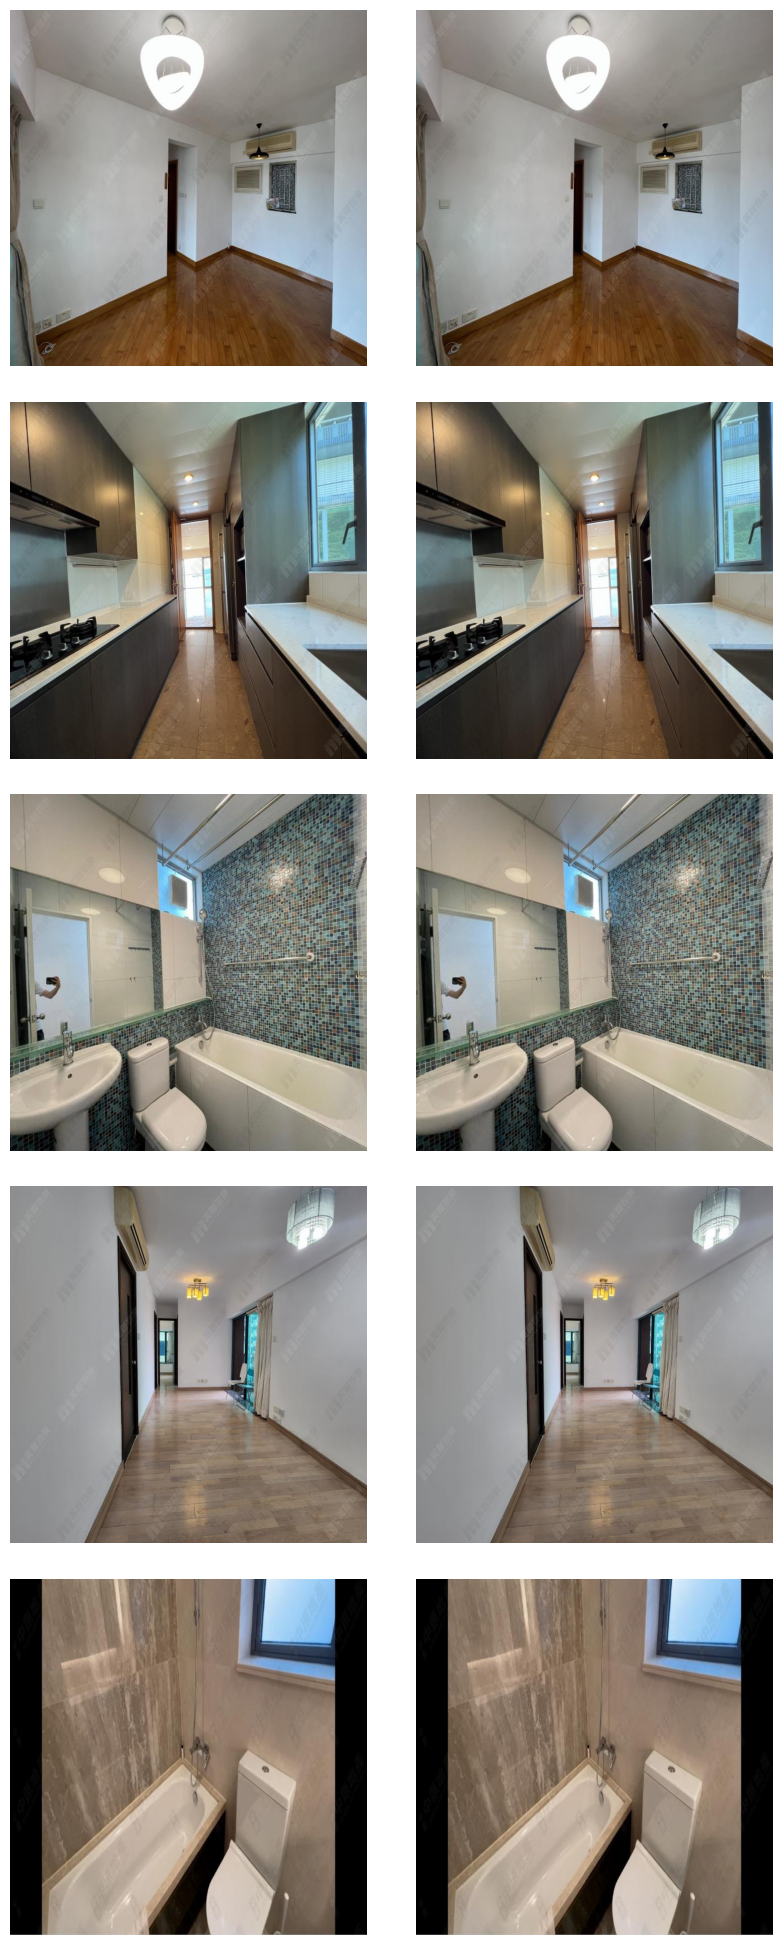

In [ ]:
fig,axes=plt.subplots(5,2,figsize=(10,25))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

test_img_list=list(sorted(os.listdir(test_imgs_dir)))
imgs_name=np.random.choice(test_img_list,5)

for i,img_name in enumerate(imgs_name):
    #ground truth
    show_bbox(img_name,test_imgs_dir,test_labels_dir,axis=axes[i,0])

    #predicted label
    show_bbox(img_name,test_imgs_dir,prediction_dir,axis=axes[i,1])

plt.savefig("2.png")

# **Data Augmentation**

In [ ]:
import cv2
import os

image_folder = "/content/all_finalize--3/train"
images = []
for filename in os.listdir(image_folder):
    img = cv2.imread(os.path.join(image_folder, filename))
    if img is not None:
        images.append(img)


In [ ]:
import json

label_folder = "/content/all_finalize--3/train/labels"
labels = []

for filename in images:
    label_filename = filename.replace(".jpg", ".json")
    with open(os.path.join(label_folder, label_filename), 'r') as f:
        label_data = json.load(f)
        labels.append(label_data)


In [ ]:
X = np.array(images)
y = np.array([label["class_label"] for label in labels])

In [ ]:
from imgaug import augmenters as iaa
import numpy as np

def augment_images(images):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # Horizontal flips
        iaa.Crop(percent=(0, 0.1)),  # Random crops
        iaa.Affine(rotate=(-25, 25)),  # Random rotations
        iaa.GaussianBlur(sigma=(0, 3.0)),  # Gaussian blur
        iaa.Multiply((0.8, 1.2)),  # Change brightness
        iaa.ContrastNormalization((0.75, 1.5)),  # Change contrast
    ])
    augmented_images = seq(images=images)
    return augmented_images

augmented_images = augment_images(images)


In [ ]:
augmented_image_folder = "path_to_save_augmented_images"
os.makedirs(augmented_image_folder, exist_ok=True)

for i, img in enumerate(augmented_images):
    cv2.imwrite(os.path.join(augmented_image_folder, f"augmented_{i}.jpg"), img)


# **RCNN model**

In [ ]:
def create_rcnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the result to feed into a DNN
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


In [ ]:
input_shape = (660, 660, 3)  # Example input shape (adjust based on your images)
num_classes = 24  # Adjust based on the number of classes in your dataset

model = create_rcnn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import numpy as np

# Assuming these are your data loading/preprocessing functions
def load_and_preprocess_data():
    # Load your data here
    augmented_images = []  # Replace with actual data loading logic
    labels = []            # Replace with actual data loading logic

    # Example logic to populate augmented_images and labels
    # augmented_images = [np.random.rand(224, 224, 3) for _ in range(100)]  # Example image data
    # labels = [{"class_label": np.random.randint(0, 20)} for _ in range(100)]  # Example label data

    return augmented_images, labels

# Load data
augmented_images, labels = load_and_preprocess_data()

# Debugging prints
print("Type of augmented_images:", type(augmented_images))
print("Length of augmented_images:", len(augmented_images))

print("Type of labels:", type(labels))
print("Length of labels:", len(labels))

if len(augmented_images) > 0:
    print("First item in augmented_images:", augmented_images[0])

if len(labels) > 0:
    print("First item in labels:", labels[0])

# Convert to numpy arrays
X_train = np.array(augmented_images)
y_train = np.array([label["class_label"] for label in labels])

# Verify shapes
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Train the model if data is not empty
if len(X_train) > 0 and len(y_train) > 0:
    model = create_cnn_model((224, 224, 3), 20)  # Adjust input shape and num_classes as needed
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
else:
    print("Training data is empty. Please check your data preprocessing steps.")


In [ ]:
X_train = np.array(augmented_images)
y_train = np.array([label["class_label"] for label in labels])  # Adjust based on your labels

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
